# 1- Training and Test Dataset for RF model

In [38]:
# Importing libraries
import gdal
import ogr        # to read vector files
import numpy as np
import pandas as pd
import geopandas as gpd

from skimage import exposure
from skimage.segmentation import quickshift
import time
from skimage.segmentation import slic
import scipy

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
# Load the map include all the bands (2-7) - we can clip the study of area
# this map has loaded in QGIS
data_path = 'D:/desktop/out_qgis/clip_merged.tif'
data_set = gdal.Open(data_path)
nRows = data_set.RasterYSize
nCols = data_set.RasterXSize

In [3]:
# we read the shapefile which has been obtaind by separating training data (points were allocated as water, urban, forest ... 
# to identify the number of land use/Land cover) in QGIS
gdf = gpd.read_file('D:/desktop/out_qgis/truth_data_subset.shp')
gdf

,lctype,geometry
0,water,POINT (619702.306 4532704.428)
1,water,POINT (628207.399 4537176.178)
2,water,POINT (645173.745 4539894.301)
3,water,POINT (662359.295 4495790.569)
4,water,POINT (651486.804 4494913.755)
...,...,...
61,bare_land,POINT (620777.773 4497245.532)
62,bare_land,POINT (627156.593 4500051.336)
63,bare_land,POINT (610513.572 4495130.218)
64,bare_land,POINT (603340.139 4495590.546)


In [4]:
# Identify the name of classes we have
class_names = gdf['lctype'].unique()
print('Class names', class_names)

Class names ['water' 'vegetation' 'urban' 'bare_land']


In [5]:
# Here give number to each class_names
# add 1 to start 1 index instead of 0 index
class_ids = np.arange(class_names.size) + 1
print('Class ids', class_ids)

Class ids [1 2 3 4]


In [6]:
# add a column 
# build DataFrame with the id column
gdf['id'] = gdf['lctype'].map(dict(zip(class_names, class_ids)))
gdf.head()

,lctype,geometry,id
0,water,POINT (619702.306 4532704.428),1
1,water,POINT (628207.399 4537176.178),1
2,water,POINT (645173.745 4539894.301),1
3,water,POINT (662359.295 4495790.569),1
4,water,POINT (651486.804 4494913.755),1


In [7]:
# create and separate Train and Test dataset
gdf_train = gdf.sample(frac=0.7)
gdf_test = gdf.drop(gdf_train.index)
print('gdf shape', gdf.shape, 'training shape', gdf_train.shape, 'test shape', gdf_test.shape)
# to save (we get a name with shp format (e.g:Train.shp) in the folder)
gdf_train.to_file('D:/desktop/out_qgis/Train.shp')
gdf_test.to_file('D:/desktop/out_qgis/Test.shp')

gdf shape (66, 3) training shape (46, 3) test shape (20, 3)


# 2- Rasterize Shapefile Training Data

In [9]:
# Read Training data built in the previous phase
train_path = 'D:/desktop/out_qgis/Train.shp'
train_data = ogr.Open(train_path)
layer = train_data.GetLayer()

In [10]:
# Create a memory raster to rasterize into
driver = gdal.GetDriverByName('MEM')   # MEM = memory
# when using 'MEM', to Create target dataset, we do not need to identify an address so just give '' empty
# 1 is the number of band
target_data = driver.Create('', data_set.RasterXSize, data_set.RasterYSize, 1, gdal.GDT_UInt16)    # GDT_UInt16 = dataType
target_data.SetGeoTransform(data_set.GetGeoTransform())
target_data.SetProjection(data_set.GetProjection())
# rasterize 
#options = ['ATTRIBUTE=id']
gdal.RasterizeLayer(target_data, [1], layer,  options = ['ATTRIBUTE=id'])    # [1] = num of bands

data1 = target_data.GetRasterBand(1).ReadAsArray()
print('min', data1.min(), 'max', data1.max(), 'mean', data1.mean())

min 0 max 4 mean 2.5999347223001128e-05


Notice: to specify target dataset, the max should be equal the number of Classes (here the num of classes was 4)

if the data1.max became 255 is wrong and we do'nt get the desired result

Also, it is very essential to determine options=['ATTRIBUTE=id'] in gdal.RasterizeLayer because this phase will show data1.max
correctly, without this, we would get wrong result.

# 3- Image Segmentation

The difference between Slic and Quickshift is that slic is faster than quickshift

In [12]:
# load the main map (include all bands (2-7)) in order to get band's number
data = 'D:/desktop/out_qgis/clip_merged.tif'

driverTiff = gdal.GetDriverByName('GTiff')
study_ds = gdal.Open(data)
nBands = study_ds.RasterCount

band_data = []
print('bands', study_ds.RasterCount, 'rows', study_ds.RasterYSize, 'columns', study_ds.RasterXSize)

for i in range(1, nBands+1):
    band = study_ds.GetRasterBand(i).ReadAsArray()    # To convert as an array
    band_data.append(band)

# by dstack, we reshape array 2D to 3D ->  (rows, columns, bands)
band_data = np.dstack(band_data)

bands 6 rows 1777 columns 2619


In [13]:
band_data.shape

(1777, 2619, 6)

In [14]:
# rescale band data
img = exposure.rescale_intensity(band_data)

In [19]:
# do segmentation with slic and quickshift (slic is faster than quickshift)
segments = slic(img, n_segments=500000, compactness=0.1)
#segments = quickshift(img,ratio=0.99, max_dist=5, convert2lab=False)
print('segment complete')

segment complete


In [20]:
# save segments to raster
SegmentsOutput = 'D:/desktop/out_qgis/segments_final.tif'   

segments_data = driverTiff.Create(SegmentsOutput, study_ds.RasterXSize, study_ds.RasterYSize,
                               1, gdal.GDT_Float32)   # 1 = number of band ,  dtype = gdal.GDT_Float32
segments_data.SetGeoTransform(study_ds.GetGeoTransform())
segments_data.SetProjection(study_ds.GetProjectionRef())
segments_data.GetRasterBand(1).WriteArray(segments)
segments_data = None

# 4- Get Statistics for Image Segments

Here we identified the number of segment's pixels and bands

In [21]:
def segment_features(segment_pixels):
    features = []
    npixels, nbands = segment_pixels.shape
    for b in range(nbands):
        stats = scipy.stats.describe(segment_pixels[:, b])  
        band_stats = list(stats.minmax) + list(stats)[2:]
        if npixels == 1:
            # in this case the variance = nan, change it 0.0
            band_stats[3] = 0.0
        features += band_stats
    return features

In [ ]:
# group pixels of segment_ids
obj_start = time.time()
# for each of segments, we have an id, an object and an object_id
segment_ids = np.unique(segments)   # segment_id has the id for each segment
objects = []
object_ids = []

for id in segment_ids:
    segment_pixels = img[segments == id]         # img is 3D (rows, columns, channels)
    print('pixels for id', id, segment_pixels.shape)
    # every object has feature which come from segment's feature 
    object_features = segment_features(segment_pixels)
    # object has data that correspond to each segment
    objects.append(object_features)    # object is needed for training data
    object_ids.append(id)

In [23]:
print('created', len(objects), 'objects with', len(objects[0]), 'variables in', time.time()-obj_start, 'second')

created 25048 objects with 36 variables in 788.4850730895996 second


# 5- Assign Classification to Image Segments for object based Image Classification

In [24]:
# we read target dataset in an array
ground_truth = target_data.GetRasterBand(1).ReadAsArray()

# class value should be numbered from 1 to the num of classes
classes = np.unique(ground_truth)[1:]     # we do not have 0 so [1:] means upper than 0
print('class value', classes)

class value [1 2 3 4]


In [25]:
segments_per_class = {}
for k in classes:
    segments_of_class = segments[ground_truth == k]   # where ground_truth is equal to k in segments
    # add segmets_of_class to dict
    segments_per_class[k] = set(segments_of_class)
    print('Training segment for class', k, ':', len(segments_of_class))

Training segment for class 1 : 10
Training segment for class 2 : 9
Training segment for class 3 : 15
Training segment for class 4 : 12


In [26]:
# To make sure that segments are not a multiple classes, or make sure each class has not more one class
intersection = set()
accum = set()

for class_segments in segments_per_class.values():
    # this code means any accum intersection with class_segments sould be added to intersection
    intersection |= accum.intersection(class_segments)    
    accum |= class_segments                               
    

# 6- Random Forest Image Classification

In [28]:
# 1- create training image
train_img = np.copy(segments)
# 2- need to treshold to identify maximum of segment value is
threshold = train_img.max() + 1

# loop for classes we have

for k in classes:
    class_label = threshold + k
    # each segment sould be equal class_label
    for segment_id in segments_per_class[k]:
        train_img[train_img == segment_id] = class_label    # to change train_img to class_label

train_img[train_img <= threshold] = 0
train_img[train_img > threshold] -= threshold

In [29]:
training_objects = []
training_labels = []

for k in classes:
    class_train_object = [value for i, value in enumerate(objects) if segment_ids[i] in segments_per_class[k]]
    # this code will show the repeat of class,
    # for example, if we had 15 segment represented water, we would then get number of 3 that repeated 15 times
    training_labels += [k] * len(class_train_object)
    # add training_objects
    training_objects += class_train_object
    print('Training objecs for class', k, ':', len(class_train_object))

Training objecs for class 1 : 10
Training objecs for class 2 : 9
Training objecs for class 3 : 14
Training objecs for class 4 : 12


In [30]:
model = RandomForestClassifier(n_jobs=-1)
model.fit(training_objects, training_labels)
print('Fitting Random Forest Classifier')

Fitting Random Forest Classifier


In [31]:
predicted = model.predict(objects)
print('Predicting Classifications')

Predicting Classifications


In [67]:
# copy of segments
clf = np.copy(segments)
# predict segment_id

for segment_id, k in zip(segment_ids, predicted):
    clf[clf == segment_id] = k
    
print('Prediction applied to numpy array')
    
# make a mask to show us where we have data and do not have data
mask = np.sum(img, axis=2)
mask[mask > 0.0] = 1.0
mask[mask == 0.0] = -1.0
clf = np.multiply(clf, mask)
clf[clf < 0] = -9999.0

Prediction applied to numpy array


In [68]:
# save and visualize classification data

clf_ds = driverTiff.Create('D:/desktop/out_qgis/Classified.tif', study_ds.RasterXSize, study_ds.RasterYSize,
                          1, gdal.GDT_Float32)
clf_ds.SetGeoTransform(study_ds.GetGeoTransform())
clf_ds.SetProjection(study_ds.GetProjectionRef())
clf_ds.GetRasterBand(1).SetNoDataValue(-9999.0)
clf_ds.GetRasterBand(1).WriteArray(clf)
clf_ds = None

# 7- Accuracy

In [64]:
data_path = 'D:/desktop/out_qgis/clip_merged.tif'

driverTiff = gdal.GetDriverByName('GTiff')
data_set = gdal.Open(data_path)

In [69]:
# Test data
# This need for accuracy the model
test_path = 'D:/desktop/out_qgis/Test.shp'
test_data = ogr.Open(test_path)
layer = test_data.GetLayer() 

driver = gdal.GetDriverByName('MEM') 
target_test = driver.Create('', data_set.RasterXSize, data_set.RasterYSize, 1, gdal.GDT_UInt16)    # GDT_UInt16 = dataType
target_test.SetGeoTransform(data_set.GetGeoTransform())
target_test.SetProjection(data_set.GetProjection())
# rasterize 
gdal.RasterizeLayer(target_test, [1], layer,  options = ['ATTRIBUTE=id'])    # [1] = num of bands

truth_data = target_test.GetRasterBand(1).ReadAsArray()
print('min', truth_data.min(), 'max', truth_data.max(), 'mean', truth_data.mean())

min 0 max 4 mean 9.239437442884698e-06


In [70]:
pred_data = gdal.Open('D:/desktop/out_qgis/Classified.tif')
prediction = pred_data.GetRasterBand(1).ReadAsArray()

# To find locations in truth where are not zero
idx_nonzero = np.nonzero(truth_data)

# confusion matrix
cm = confusion_matrix(truth_data[idx_nonzero], prediction[idx_nonzero]) 
display(cm)

array([[6, 0, 0, 1],
       [0, 3, 0, 1],
       [0, 0, 8, 0],
       [0, 0, 0, 1]], dtype=int64)

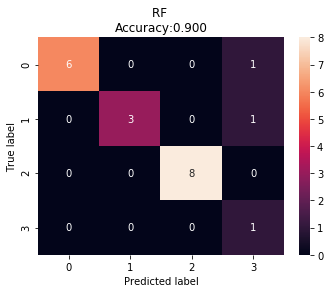

In [73]:
np.set_printoptions(precision=2)

plt.figure(figsize=(5.5,4))
sns.heatmap(cm, annot=True)
plt.title('RF \nAccuracy:{0:.3f}'.format(accuracy_score(truth_data[idx_nonzero], prediction[idx_nonzero])))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()